# Liver segmentations

In [35]:
#imports
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

# Set numpy print options to avoid truncation
#np.set_printoptions(threshold=np.inf)

In [ ]:
#use first image as example

#12 and 13 are liver
#image and segmentation have the same affine matrix
#did not yet update affine and header (not necessary?)

scans_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/last scan niftis cropped"
segmentations_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/last segmentations cropped"

#load first image and segmentation
image = nib.load(os.path.join(scans_path, "CAESAR001_1_0000.nii.gz"))
segmentation = nib.load(os.path.join(segmentations_path, "CAESAR001_1.nii.gz"))

image_data = image.get_fdata()
segmentation_data = segmentation.get_fdata()

liver_mask = (segmentation_data == 12) | (segmentation_data == 13)

#apply mask to image
liver_image = np.copy(image_data)
liver_image[~liver_mask] = 0

# Find the indices of the liver mask
mask_indices = np.argwhere(liver_mask)

# Calculate the bounding box
min_indices = mask_indices.min(axis=0)
max_indices = mask_indices.max(axis=0)

print(min_indices, max_indices)

# Crop the liver image using the bounding box
cropped_liver_image = liver_image[min_indices[0]:max_indices[0]+1, min_indices[1]:max_indices[1]+1, min_indices[2]:max_indices[2]+1]
#print(cropped_liver_image.shape)
#padd with required number of zeros to correct size


# # Create a new NIfTI image
new_image = nib.Nifti1Image(cropped_liver_image, affine=image.affine, header=image.header)

# # Save the new NIfTI image to a file
output_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/boundingbox_liver_segmentations/test_liver_image.nii.gz"
nib.save(new_image, output_path)

# Display multiple plots
# for i in range(cropped_liver_image.shape[2]):
#     plt.figure()  # Create a new figure for each slice
#     plt.imshow(cropped_liver_image[:, :, i], cmap='gray')
#     plt.title(f'Slice {i}')
#     plt.axis('off')
#     plt.show()

[162 119   3] [459 349  52]


### Distribution of number of slices

In [44]:
#distribution of slices
scans_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/last scan niftis cropped"

max_slices = 0

number_of_slices = []
for scan in os.listdir(scans_path):
    image = nib.load(os.path.join(scans_path, scan))
    image_shape = image.header.get_data_shape()
    max_slices = max(max_slices, image_shape[2])    
    if image_shape[2] < 150:
        number_of_slices.append(image_shape[2])

print(len(number_of_slices))
print(max_slices)
#plt.hist(number_of_slices)
#plt.show() 

328
376


### Create segmentation and bounding box

In [ ]:
#does not update affine and header

scans_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/last scan niftis cropped"
segmentations_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/last segmentations cropped"
output_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/boundingbox_liver_segmentations"

max_dimensions = [0, 0, 0]

for scan in os.listdir(scans_path):
    print(scan)
    
    #load image and corresponding segmentation
    image = nib.load(os.path.join(scans_path, scan))

    segm_filename = scan.replace("_0000", "")
    segmentation = nib.load(os.path.join(segmentations_path, segm_filename))

    image_data = image.get_fdata()
    segmentation_data = segmentation.get_fdata()

    liver_mask = (segmentation_data == 12) | (segmentation_data == 13)

    #apply mask to image
    liver_image = np.copy(image_data)
    liver_image[~liver_mask] = 0

    # Find the indices of the liver mask
    mask_indices = np.argwhere(liver_mask)

    # Calculate the bounding box
    min_indices = mask_indices.min(axis=0)
    max_indices = mask_indices.max(axis=0)

    # Crop the liver image using the bounding box
    cropped_liver_image = liver_image[min_indices[0]:max_indices[0]+1, min_indices[1]:max_indices[1]+1, min_indices[2]:max_indices[2]+1]
    
    # Update the maximum dimensions
    max_dimensions = np.maximum(max_dimensions, cropped_liver_image.shape)

    # Create a new NIfTI image
    new_image = nib.Nifti1Image(cropped_liver_image, affine=image.affine, header=image.header)

    # Save the new NIfTI image to a file with the original name
    new_filename = scan.split(".")[0] + "_cropped.nii.gz"
    output_file_path = os.path.join(output_path, new_filename)
    nib.save(new_image, output_file_path)

print(max_dimensions)

In [ ]:
#check the shape of every image
scans_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/boundingbox_liver_segmentations"

first_dim = []
second_dim = []
third_dim = []
max_slices = 0

for scan in os.listdir(scans_path):
    image = nib.load(os.path.join(scans_path, scan))
    image_data = image.get_fdata()
    first_dim.append(image_data.shape[0])
    second_dim.append(image_data.shape[1])
    third_dim.append(image_data.shape[2])
    max_slices = max(max_slices, image_data.shape[2])

print(max_slices)


366


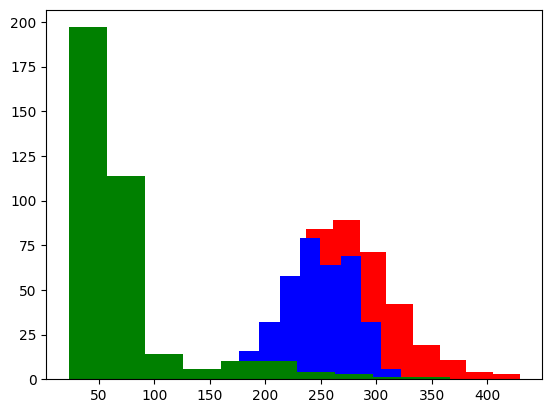

In [42]:
plt.hist(first_dim, color='red')
plt.hist(second_dim, color='blue')
plt.hist(third_dim, color='green')
plt.show()

### Add appropriate padding for every scan

In [ ]:
#add padding for all images with a 100 slices or less

boundingbox_segm_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/boundingbox_liver_segmentations"
padded_segm_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/padded_liver_segmentations"

#largest dimensions of all images
#biggest image is: [429, 341, 366]
max_dimensions = [430, 345, 100]

for scan in os.listdir(boundingbox_segm_path):
    print(scan)
    #load image
    image = nib.load(os.path.join(boundingbox_segm_path, scan))

    image_data = image.get_fdata()
    liver_image = np.copy(image_data)

    if image_data.shape[2]  <= 100:

        # Calculate the padding widths for each dimension
        pad_widths = []
        for max_dim, curr_dim in zip(max_dimensions, liver_image.shape):
            total_pad = max_dim - curr_dim
            pad_before = total_pad // 2
            pad_after = total_pad - pad_before
            pad_widths.append((pad_before, pad_after))

        # Pad the liver image with zeros to the desired size
        padded_liver_image = np.pad(liver_image, pad_widths, mode='constant', constant_values=0)

        # Modify the header to update the dimensions
        new_header = image.header.copy()
        new_header['dim'][0] = 3  # Number of dimensions
        new_header['dim'][1:4] = padded_liver_image.shape  # Update dimensions

        # Create a new NIfTI image
        new_image = nib.Nifti1Image(padded_liver_image, affine=image.affine, header=new_header)

        # Save the new NIfTI image to a file with the original name
        output_file_path = os.path.join(padded_segm_path, f"{scan[:-14]}padded.nii.gz")
        nib.save(new_image, output_file_path)

In [24]:
#downsize imgages with more than a 100 slices and pad


boundingbox_segm_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/boundingbox_liver_segmentations"
padded_segm_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/downsized_padded_liver_segmentations"

for scan in os.listdir(boundingbox_segm_path):
    #load first image and segmentation
    image = nib.load(os.path.join(boundingbox_segm_path, scan))

    image_data = image.get_fdata()
    if image_data.shape[2] > 100:
        downsized = cv2.resize(image_data, dsize=(image_data.shape[0], image_data.shape[1], 100))

        # Create a new NIfTI image
        new_image = nib.Nifti1Image(downsized, affine=image.affine, header=image.header)

        # Save the new NIfTI image to a file
        output_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/downsized_padded_liver_segmentations/test_liver_image.nii.gz"
        nib.save(new_image, output_path)
        break



error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - Can't parse 'dsize'. Expected sequence length 2, got 3
>  - Can't parse 'dsize'. Expected sequence length 2, got 3


## Sanity checks

In [18]:
# Path to the folder containing padded liver segmentations
padded_segm_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/padded_liver_segmentations"

# Initialize a variable to store the shape of the first image
reference_shape = None
all_same_size = True

# Iterate through all files in the folder
for scan in os.listdir(padded_segm_path):
    # Load the image
    image = nib.load(os.path.join(padded_segm_path, scan))
    image_data = image.get_fdata()
    
    # Get the shape of the current image
    current_shape = image_data.shape
    
    # If reference_shape is None, set it to the shape of the first image
    if reference_shape is None:
        reference_shape = current_shape
    else:
        # Compare the shape of the current image with the reference shape
        if current_shape != reference_shape:
            all_same_size = False
            print(f"Image {scan} has a different size: {current_shape}")
            break

if all_same_size:
    print("All images have the same size.")
else:
    print("Not all images have the same size.")

All images have the same size.


In [ ]:
# Define paths
input_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/boundingbox_liver_segmentations"
output_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/downsized_padded_liver_segmentations"

max_dimensions = [430, 345, 100] 

for scan in os.listdir(input_path):

    # Load image
    image = nib.load(os.path.join(input_path, scan))
    image_data = image.get_fdata()

    if image_data.shape[2] > 100:
        print(scan)

        # Calculate the step size to keep the number of slices under 100
        step_size = math.ceil(image_data.shape[2] / 100)

        # Use the slicer object to extract a specific slice
        resampled_image = image.slicer[:, :, ::step_size]  

        image_data = resampled_image.get_fdata()

         # Calculate the padding widths for each dimension
        pad_widths = []
        for max_dim, curr_dim in zip(max_dimensions, image_data.shape):
            total_pad = max_dim - curr_dim
            pad_before = total_pad // 2
            pad_after = total_pad - pad_before
            pad_widths.append((pad_before, pad_after))

        # Pad the liver image with zeros to the desired size
        padded_image = np.pad(image_data, pad_widths, mode='constant', constant_values=0)

        # Modify the header to update the dimensions
        new_header = resampled_image.header.copy()
        new_header['dim'][0] = 3  # Number of dimensions
        new_header['dim'][1:4] = padded_liver_image.shape  # Update dimensions

        # Create a new NIfTI image
        new_image = nib.Nifti1Image(padded_image, affine=image.affine, header=new_filename)

        
        # Save the resampled image to a file with the original name
        output_file_path = os.path.join(output_path, scan)
        nib.save(new_image, output_file_path)
        break



CAESAR032_1_0000_cropped.nii.gz


NameError: name 'max_slices' is not defined

122.0